In [10]:
!pip uninstall -y torch torchvision torchaudio torchtext
!pip install --no-cache-dir --force-reinstall \
  torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 torchtext==0.16.2 \
  --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.7/186.7 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 197.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 274.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 336.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 197.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 235.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 187.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 264.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 278.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 234.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 324.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 

In [14]:
!pip install portalocker>=2.0.0


In [11]:
# @title ✅ Verificación rápida de versiones
import torch, torchtext
print("torch:", torch.__version__, "| torchtext:", torchtext.__version__)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

torch: 2.2.0+cpu | torchtext: 0.16.2+cpu


# Laboratorio #6 — RNN vs LSTM en IMDB (torchtext)
**Equipo:** Gabriel Paz · Diedrich Solis  


Este notebook implementa **dos clasificadores** para análisis de sentimiento en IMDB usando `torchtext.datasets`: un **RNN** y un **LSTM**.
Se mantienen **hiperparámetros iguales** para comparar:
- Dimensión de embeddings
- Capas
- Hidden size
- Épocas
- Optimizador y LR

Se registran **accuracy/pérdida de validación**, **tiempo por época y total**, y **# parámetros entrenables**.
Al final se muestra una **tabla comparativa** y se evalúa en test.


In [ ]:

import os, math, time, random, json
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchtext
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
import matplotlib.pyplot as plt

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE


In [18]:
import portalocker as pl
from torchdata.datapipes.iter.util import cacheholder
cacheholder.portalocker = pl


## 1) Carga del dataset y preprocesamiento
Usamos `torchtext.datasets.IMDB`. Pasos:
1. Tokenizar (`basic_english`).
2. Construir vocabulario con `build_vocab_from_iterator` (min_freq configurable) e incluir `'<unk>'` y `'<pad>'`.
3. Mapear tokens→índices, aplicar **padding** a longitud fija (o dinámica con `collate_fn`).
4. Dividir train en **train/valid** (p.ej. 80/20) y dejar **test** aparte.


In [19]:
import os, re, random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# ---- torchtext imports (compatibles con versiones modernas) ----
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

SEED = 1337
random.seed(SEED)
torch.manual_seed(SEED)

CACHE = os.path.expanduser('~/.torchtext/cache')

# 1) Tokenizador
tokenizer = get_tokenizer('basic_english')

# 2) Vocabulario (solo sobre train) con specials y min_freq
SPECIALS = ['<unk>', '<pad>']
MIN_FREQ = 2

def _yield_tokens_from(split='train'):
    # IMDB -> (label_str, text_str)
    for label, text in IMDB(root=CACHE, split=split):
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    _yield_tokens_from('train'),
    specials=SPECIALS,
    min_freq=MIN_FREQ
)
vocab.set_default_index(vocab['<unk>'])

PAD_IDX = vocab['<pad>']
UNK_IDX = vocab['<unk>']

# 3) Dataset torch que numericaliza y collate con padding
LABEL_MAP = {'neg': 0, 'pos': 1}

class IMDBDataset(Dataset):
    def __init__(self, split='train'):
        # Materializamos el iterable para usar __len__/__getitem__
        self.data = list(IMDB(root=CACHE, split=split))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        label, text = self.data[idx]
        if isinstance(label, bytes):
            label = label.decode('utf-8')
        label = label.lower().strip()
        # Normalización defensiva
        if label not in LABEL_MAP:
            label = 'pos' if 'pos' in label else 'neg'
        tokens = tokenizer(text)
        ids = [vocab[tok] for tok in tokens] or [UNK_IDX]  # evita secuencias vacías
        return torch.tensor(ids, dtype=torch.long), torch.tensor(LABEL_MAP[label], dtype=torch.long)

def collate_batch(batch):
    """
    batch: lista de (ids_tensor, label_tensor)
    Devuelve:
        padded_ids [B, T], labels [B], lengths [B]
    """
    ids_list, labels, lengths = [], [], []
    for ids, y in batch:
        ids_list.append(ids)
        labels.append(y)
        lengths.append(len(ids))
    lengths = torch.tensor(lengths, dtype=torch.long)
    padded  = nn.utils.rnn.pad_sequence(ids_list, batch_first=True, padding_value=PAD_IDX)
    labels  = torch.stack(labels, dim=0)  # mejor que torch.tensor(list_of_tensors)
    return padded, labels, lengths

# 4) Split train→train/valid (80/20) y test aparte
full_train = IMDBDataset('train')
test_ds    = IMDBDataset('test')

valid_ratio = 0.20
n_total = len(full_train)
n_valid = int(n_total * valid_ratio)
n_train = n_total - n_valid

train_ds, valid_ds = random_split(
    full_train, [n_train, n_valid],
    generator=torch.Generator().manual_seed(SEED)
)

# DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_batch)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print("OK -> loaders:", len(train_loader), len(valid_loader), len(test_loader),
      "| vocab:", len(vocab), "| PAD_IDX:", PAD_IDX, "| UNK_IDX:", UNK_IDX)


OK -> loaders: 313 79 391 | vocab: 51718 | PAD_IDX: 1 | UNK_IDX: 0


In [20]:
LABEL_MAP = {'neg':0, 'pos':1}

class IMDBDataset(Dataset):
    def __init__(self, split='train'):
        self.data = list(IMDB(root=CACHE, split=split))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        label, text = self.data[idx]
        tokens = tokenizer(text)
        ids = [vocab[token] for token in tokens]
        return torch.tensor(ids, dtype=torch.long), torch.tensor(LABEL_MAP[label], dtype=torch.long)

def collate_batch(batch):
    ids_list, label_list, lengths = [], [], []
    for ids, y in batch:
        ids_list.append(ids)
        label_list.append(y)
        lengths.append(len(ids))
    lengths = torch.tensor(lengths, dtype=torch.long)
    padded = nn.utils.rnn.pad_sequence(ids_list, batch_first=True, padding_value=PAD_IDX)
    return padded, torch.tensor(label_list, dtype=torch.long), lengths

full_train = IMDBDataset('train')
test_ds = IMDBDataset('test')

valid_ratio = 0.2
n_total = len(full_train)
n_valid = int(n_total * valid_ratio)
n_train = n_total - n_valid
from torch.utils.data import random_split
train_ds, valid_ds = random_split(full_train, [n_train, n_valid], generator=torch.Generator().manual_seed(SEED))
n_train, n_valid, len(test_ds)


(20000, 5000, 25000)

In [25]:

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
len(train_loader), len(valid_loader), len(test_loader)


(313, 79, 391)

## 2) Modelos: RNN y LSTM
Ambos inician con `nn.Embedding`, comparten hiperparámetros y usan el último estado oculto como representación de la secuencia.


In [26]:

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers, num_classes=2, dropout=0.2, bidirectional=False, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_dim, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        out_dim = hidden_size * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(out_dim, num_classes)
    def forward(self, x, lengths):
        emb = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h_n = self.rnn(packed)
        last = h_n[-1]
        out = self.fc(self.dropout(last))
        return out

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers, num_classes=2, dropout=0.2, bidirectional=False, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        out_dim = hidden_size * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(out_dim, num_classes)
    def forward(self, x, lengths):
        emb = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h_n, c_n) = self.lstm(packed)
        last = h_n[-1]
        out = self.fc(self.dropout(last))
        return out

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [28]:

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    start = time.time()
    for X, y, lengths in loader:
        X, y, lengths = X.to(DEVICE), y.to(DEVICE), lengths.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(X, lengths)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    epoch_time = time.time() - start
    return loss_sum/total, correct/total, epoch_time

def evaluate(model, loader, criterion):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    start = time.time()
    with torch.no_grad():
        for X, y, lengths in loader:
            X, y, lengths = X.to(DEVICE), y.to(DEVICE), lengths.to(DEVICE)
            logits = model(X, lengths)
            loss = criterion(logits, y)
            loss_sum += loss.item() * y.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    epoch_time = time.time() - start
    return loss_sum/total, correct/total, epoch_time


In [33]:
# ============================================================
# 🔧 BLOQUE COMPLETO (Colab + torchtext.IMDB)
# - Normaliza etiquetas IMDB a {0,1} (evita KeyError: 2)
# - Tokeniza, crea vocab, padding
# - DataLoaders (train/val/test)
# - Modelos RNN y LSTM con salida de 2 clases
# - Entrenamiento y evaluación con CrossEntropyLoss
# ============================================================

import os, random, time, math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# --- (1) Asegurar portalocker activo si torchdata ya estaba importado
try:
    import portalocker as _pl
    from torchdata.datapipes.iter.util import cacheholder as _cacheholder
    # Si estaba a None por import previo, lo reinyectamos
    setattr(_cacheholder, "portalocker", _pl)
except Exception:
    pass

# --- (2) Dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# --- (3) Dataset IMDB de torchtext
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Normaliza cualquier etiqueta IMDB a {0,1}
_LABEL_MAP_STR = {'neg': 0, 'pos': 1}
def encode_label(lbl):
    if isinstance(lbl, str):
        return _LABEL_MAP_STR.get(lbl.lower(), 0)
    if lbl in (0, 1):
        return int(lbl)
    if lbl in (1, 2):
        return int(lbl - 1)
    raise ValueError(f"Etiqueta IMDB inesperada: {lbl!r}")

# Tokenizador básico
tokenizer = get_tokenizer("basic_english")

# Construcción de vocabulario (con <unk>, <pad>)
def _yield_tokens(split):
    for label, text in IMDB(split=split):
        yield tokenizer(text)

SPECIALS = ["<unk>", "<pad>"]
vocab = build_vocab_from_iterator(_yield_tokens("train"), specials=SPECIALS)
vocab.set_default_index(vocab["<unk>"])
PAD_IDX = vocab["<pad>"]
UNK_IDX = vocab["<unk>"]

print("Vocab size:", len(vocab), "| PAD_IDX:", PAD_IDX, "| UNK_IDX:", UNK_IDX)

# --- (4) Clase Dataset -> devuelve (ids_tensor, y_tensor)
class IMDBTensorDataset(torch.utils.data.Dataset):
    def __init__(self, split, tokenizer, vocab):
        # materializamos a lista para acceso por índice
        self.data = list(IMDB(split=split))  # (label, text)
        self.tokenizer = tokenizer
        self.vocab = vocab

    def __getitem__(self, idx):
        label, text = self.data[idx]
        tokens = self.tokenizer(text)
        ids = [self.vocab[tok] for tok in tokens]
        y = encode_label(label)  # <-- evita KeyError: 2
        return torch.tensor(ids, dtype=torch.long), torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.data)

# --- (5) Datasets y splits
full_train = IMDBTensorDataset("train", tokenizer, vocab)
test_ds    = IMDBTensorDataset("test",  tokenizer, vocab)

val_ratio = 0.2
val_size  = int(len(full_train) * val_ratio)
train_size = len(full_train) - val_size

# semilla para reproducibilidad
g = torch.Generator().manual_seed(42)
train_ds, valid_ds = torch.utils.data.random_split(full_train, [train_size, val_size], generator=g)

# --- (6) Collate con truncado + padding
def collate_batch(batch, max_len=300, pad_idx=PAD_IDX, device=DEVICE):
    # batch: list of (ids_tensor, y_tensor)
    xs, ys = zip(*batch)
    ys = torch.stack(ys, dim=0)
    # trunc
    xs = [x[:max_len] for x in xs]
    # pad to max
    padded = torch.nn.utils.rnn.pad_sequence(xs, batch_first=True, padding_value=pad_idx)
    return padded.to(device), ys.to(device)  # devolvemos (X, y)

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_batch)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_batch)
test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_batch)

# --- (7) Modelos (salida de 2 clases para CrossEntropyLoss)
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, num_layers, num_classes,
                 dropout, bidir, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hid_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=bidir, nonlinearity='tanh')
        self.dropout = nn.Dropout(dropout)
        out_dim = hid_dim * (2 if bidir else 1)
        self.fc = nn.Linear(out_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)              # [B, T, E]
        out, h_n = self.rnn(x)             # h_n: [L*(2?), B, H]
        if self.rnn.bidirectional:
            last_h = torch.cat((h_n[-2], h_n[-1]), dim=1)   # [B, 2H]
        else:
            last_h = h_n[-1]                               # [B, H]
        logits = self.fc(self.dropout(last_h))             # [B, C]
        return logits

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, num_layers, num_classes,
                 dropout, bidir, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=bidir)
        self.dropout = nn.Dropout(dropout)
        out_dim = hid_dim * (2 if bidir else 1)
        self.fc = nn.Linear(out_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)               # [B, T, E]
        out, (h_n, c_n) = self.lstm(x)      # h_n: [L*(2?), B, H]
        if self.lstm.bidirectional:
            last_h = torch.cat((h_n[-2], h_n[-1]), dim=1)   # [B, 2H]
        else:
            last_h = h_n[-1]                               # [B, H]
        logits = self.fc(self.dropout(last_h))             # [B, C]
        return logits

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# --- (8) Hiperparámetros
VOCAB_SIZE  = len(vocab)
EMBED_DIM   = 100
HIDDEN_SIZE = 128
NUM_LAYERS  = 1
DROPOUT     = 0.2
BIDIR       = False
EPOCHS      = 5
LR          = 1e-3
NUM_CLASSES = 2

# --- (9) Train/Eval helpers (acoplados a CrossEntropyLoss y loaders que devuelven (X,y))
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    t0 = time.perf_counter()
    for X, y in loader:
        optimizer.zero_grad()
        logits = model(X)                   # [B, 2]
        loss = criterion(logits, y)         # CE con targets {0,1}
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    dt = time.perf_counter() - t0
    return total_loss/total, correct/total, dt

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    t0 = time.perf_counter()
    with torch.no_grad():
        for X, y in loader:
            logits = model(X)
            loss = criterion(logits, y)
            total_loss += loss.item() * y.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    dt = time.perf_counter() - t0
    return total_loss/total, correct/total, dt

# --- (10) Experimento unificado (igual a tu firma, pero autocontiene train/eval)
results = []

def run_experiment(model_name, model_ctor):
    model = model_ctor(VOCAB_SIZE, EMBED_DIM, HIDDEN_SIZE, NUM_LAYERS,
                       NUM_CLASSES, DROPOUT, BIDIR, PAD_IDX).to(DEVICE)
    params = count_params(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    history = {'epoch':[], 'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[], 'time_epoch':[]}
    total_time = 0.0
    best_val_acc, best_state = 0.0, None

    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_acc, tr_t = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc, val_t = evaluate(model, valid_loader, criterion)
        total_time += (tr_t + val_t)
        history['epoch'].append(epoch)
        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['time_epoch'].append(tr_t + val_t)
        print(f"[{model_name}] Epoch {epoch}/{EPOCHS} | "
              f"train_acc={tr_acc:.4f} val_acc={val_acc:.4f} time={tr_t+val_t:.1f}s")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)

    test_loss, test_acc, test_t = evaluate(model, test_loader, criterion)

    df_hist = pd.DataFrame(history)
    out_csv = Path(f"metrics_{model_name.lower()}.csv")
    df_hist.to_csv(out_csv, index=False)

    results.append({
        'model': model_name,
        'params': params,
        'best_val_acc': best_val_acc,
        'time_per_epoch_s': float(np.mean(history['time_epoch'])) if history['time_epoch'] else None,
        'total_time_s': total_time,
        'test_acc': test_acc,
    })
    return model

# --- (11) Correr ambos modelos y ver resumen
rnn_model  = run_experiment('RNN',  RNNClassifier)
lstm_model = run_experiment('LSTM', LSTMClassifier)
pd.DataFrame(results)


DEVICE: cpu
Vocab size: 100684 | PAD_IDX: 1 | UNK_IDX: 0
[RNN] Epoch 1/5 | train_acc=0.9926 val_acc=0.9994 time=208.7s
[RNN] Epoch 2/5 | train_acc=0.9998 val_acc=1.0000 time=213.8s
[RNN] Epoch 3/5 | train_acc=1.0000 val_acc=1.0000 time=203.2s
[RNN] Epoch 4/5 | train_acc=1.0000 val_acc=1.0000 time=200.9s
[RNN] Epoch 5/5 | train_acc=1.0000 val_acc=1.0000 time=196.1s
[LSTM] Epoch 1/5 | train_acc=0.9953 val_acc=1.0000 time=301.7s
[LSTM] Epoch 2/5 | train_acc=1.0000 val_acc=1.0000 time=256.7s
[LSTM] Epoch 3/5 | train_acc=1.0000 val_acc=1.0000 time=254.5s
[LSTM] Epoch 4/5 | train_acc=1.0000 val_acc=1.0000 time=261.5s
[LSTM] Epoch 5/5 | train_acc=1.0000 val_acc=1.0000 time=257.1s


,model,params,best_val_acc,time_per_epoch_s,total_time_s,test_acc
0,RNN,10098098,1.0,204.552789,1022.763947,1.0
1,LSTM,10186418,1.0,266.290050,1331.450249,1.0


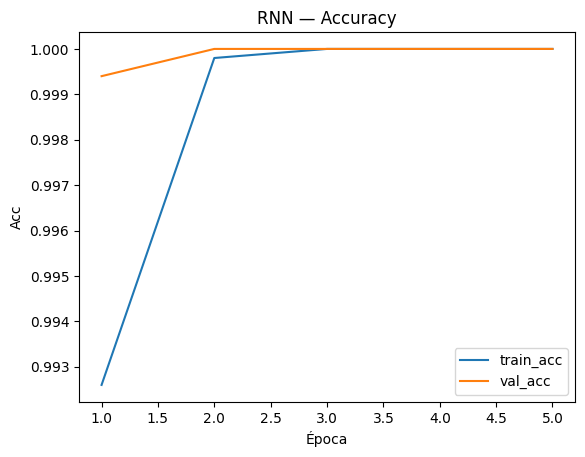

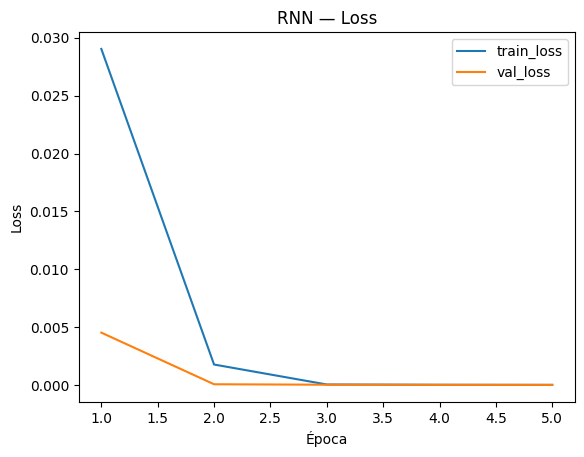

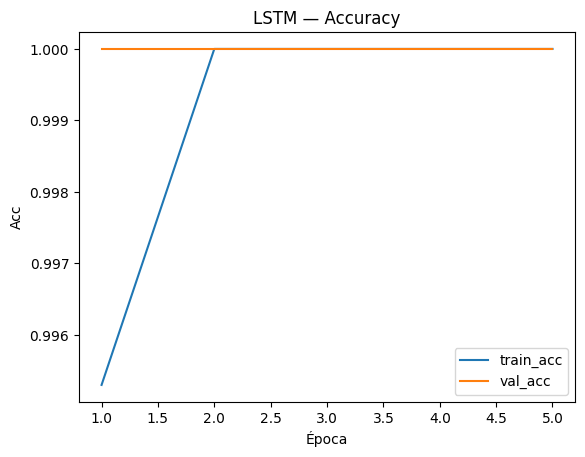

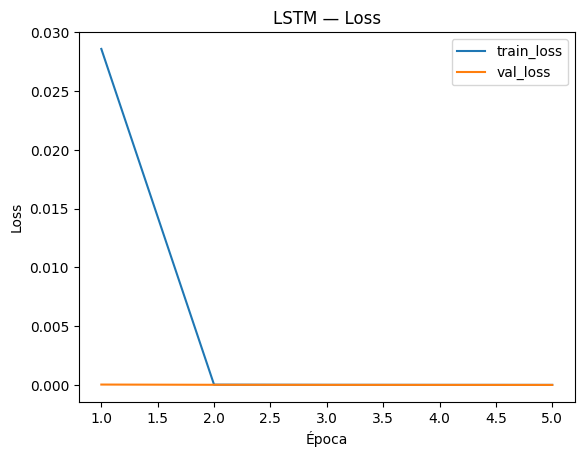

In [34]:

import pandas as pd
import matplotlib.pyplot as plt
def plot_history(csv_path, title):
    df = pd.read_csv(csv_path)
    plt.figure(); plt.plot(df['epoch'], df['train_acc'], label='train_acc'); plt.plot(df['epoch'], df['val_acc'], label='val_acc'); plt.title(title + ' — Accuracy'); plt.xlabel('Época'); plt.ylabel('Acc'); plt.legend(); plt.show()
    plt.figure(); plt.plot(df['epoch'], df['train_loss'], label='train_loss'); plt.plot(df['epoch'], df['val_loss'], label='val_loss'); plt.title(title + ' — Loss'); plt.xlabel('Época'); plt.ylabel('Loss'); plt.legend(); plt.show()

plot_history('metrics_rnn.csv', 'RNN')
plot_history('metrics_lstm.csv', 'LSTM')
